# Logistic fits to rule-based condition

This script is used for model comparison for the rule-based logistic fits to the psychometric function in section:
"Rule- and stimulus-based biases had different effects on choices and RTs." It also outputs data used for plotting in the all_conds_fits notebook.

In [1]:
imatlab_export_fig('print-svg')
set(0,'defaultfigurecolor',[1 1 1])
set(groot,'DefaultAxesFontName','Arial')


addpath('../logistic')

DATA_DIR = './data';

%eventually separate out this code and load model defs from a mat
fits(1).optionName = 'priorOnly';
fits(1).model_id = 1;
fits(1).fitmat = 'fits_lapse_priorOnly_full_01-Mar-2021.mat';
fits(1).dmat_func = @make_precue_dmat;
fits(1).title = 'full';
fits(1).nparam = 7;
fits(2).optionName = 'priorOnly';
fits(2).model_id = 2;
fits(2).fitmat = 'fits_lapse_priorOnly_noint_01-Mar-2021.mat';
fits(2).dmat_func = @make_precue_noint_dmat;
fits(2).title = 'shared slopes';
fits(2).nparam = 5;
fits(3).model_id = 3;
fits(3).fitmat = 'fits_lapse_priorOnly_noprior_01-Mar-2021.mat';
fits(3).dmat_func = @make_basic_dmat;
fits(3).title = 'base';
fits(3).nparam = 3;
fits(4).model_id = 6;
fits(4).fitmat = 'fits_lapse_priorOnly_adapt_27-Jul-2021.mat';
fits(4).dmat_func = @make_precue_adapt_dmat;
fits(4).title = 'adapt';
fits(4).nparam = 8;


data = read_data_csv(...
    fullfile(DATA_DIR,'/priorOnly_pretoneOnly_pretone_pL_pretone_pH_pretone5_05-Feb-2021.csv'));
    

## load and plot data for all models

In [2]:
datapc = data(strcmp(data.optionName,fits(1).optionName),:);
%remove missing trials (should already be done)
datapc = datapc(~isnan(datapc.choice01),:);
datapc.zSNR = zscore(datapc.SNR);
datapc.aSNR = zscore(abs(datapc.SNR));

In [3]:
%% compute average data and set up variables

datapc_ave_subj = summary_stats(datapc,{'choice01'},...
    {'subject','prior','zSNR'});
datapc_ave_all = summary_stats(datapc_ave_subj,'mean_choice01',{'prior','zSNR'});

subjects = unique(datapc_ave_subj.subject);
zsnrs = unique(datapc_ave_subj.zSNR);
priors = unique(datapc_ave_subj.prior);
fdat = cat(2, ones(100, 1), ...
    linspace(min(zsnrs), max(zsnrs), 100)');
snrs_smooth = linspace(min(datapc.SNR), max(datapc.SNR), 100)';
co = {'b','k','r'};
psych_leg={'low','neutral','high'};

## plot all models

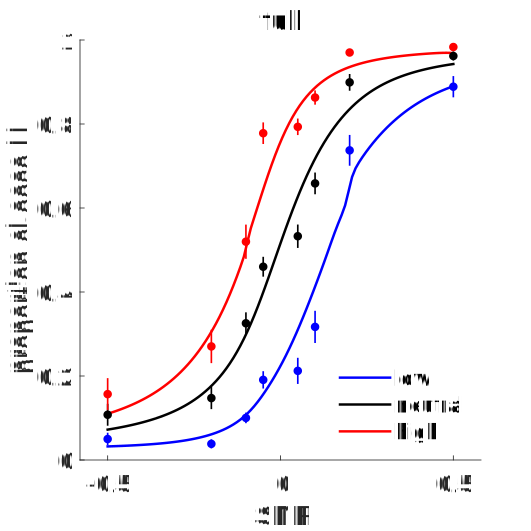

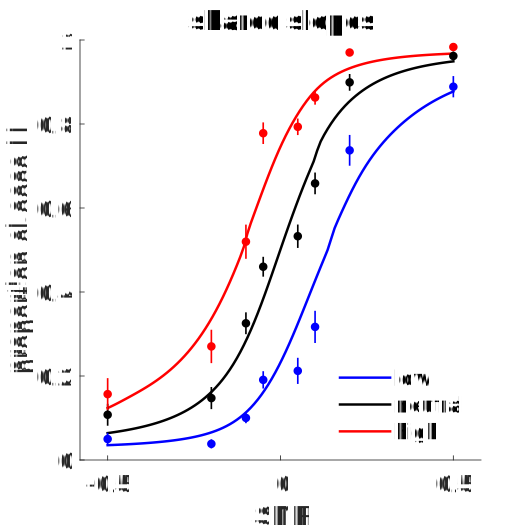

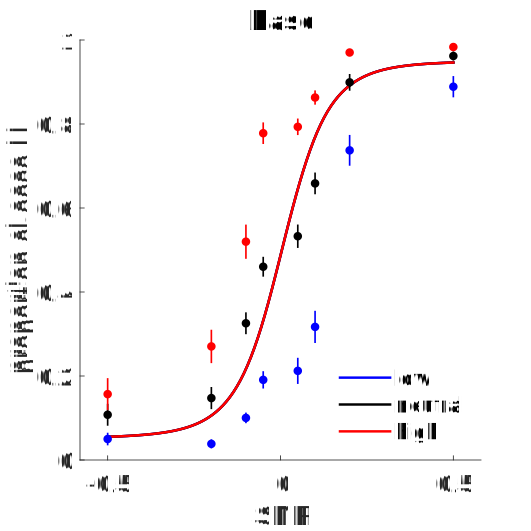

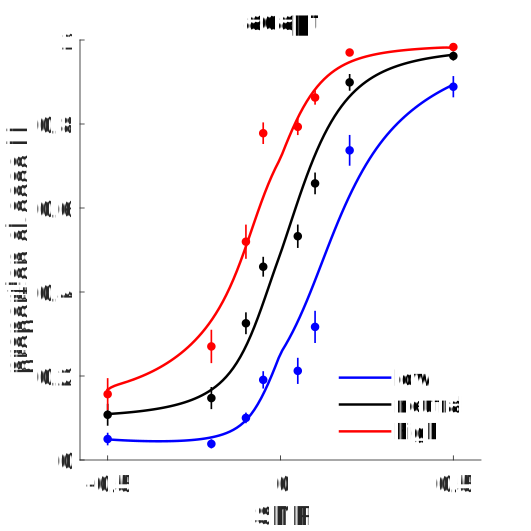

In [4]:
%compute and plot predictions for all logistic models
this_figdim = [1 1 425 425];
%this_subplot = @(m,n,p) subtightplot(m,n,p,.12,[.16 .05],[0.12 0.05]);
set(groot,'DefaultAxesFontSize',15)
set(groot,'DefaultLineLineWidth',1.5)
set(groot,'DefaultErrorBarLineWidth',1)
set(groot,'DefaultErrorBarMarkerSize',14)
set(groot,'DefaultErrorBarCapSize',0)
set(groot,'DefaultLegendBox','off')

psycho_fit_ave_out = [];
for m=1:length(fits)
    F = load(fullfile(DATA_DIR,fits(m).fitmat));
    this_dmat_func = fits(m).dmat_func;
    zsnrs_smooth = (snrs_smooth - F.norms.SNR.mean)./ F.norms.SNR.sd;
    %this_norms = F.norms;
    %this_fits_lapse = F.fits_lapse;clear F
    this_fits_pred = [];
    for s=1:height(F.fits_lapse)
        this_subj = F.fits_lapse.subject(s);
        this_fits = F.fits_lapse{s,1:fits(m).nparam};
        if strcmp(fits(m).title,'adapt')
            %adapt also needs aSNR
            asnrs_smooth = (abs(snrs_smooth) - F.norms.aSNR.mean)./ F.norms.aSNR.sd;
            this_sdata = make_smooth_data(datapc(strcmp(datapc.subject,this_subj),:),...
                {'prior'},[zsnrs_smooth asnrs_smooth],{'zSNR','aSNR'});
        else
            this_sdata = make_smooth_data(datapc(strcmp(datapc.subject,this_subj),:),...
                {'prior'},zsnrs_smooth,'zSNR');
        end
        this_sdata.pred = logist_pred(this_sdata,this_fits,this_dmat_func,[],1);
        this_sdata.subject = repmat(this_subj,height(this_sdata),1);
        this_fits_pred = [this_fits_pred;this_sdata];
    end

    %datapc_ave_subj = summary_stats(datapc,{'choice01'},...
    %    {'subject','prior','zSNR'});
    %datapc_ave_all = summary_stats(datapc_ave_subj,{'mean_choice01'},...
    %    {'prior','zSNR'});
    
    this_fits_pred_ave = varfun(@mean,this_fits_pred,'InputVariables','pred',...
        'GroupingVariables',{'subject','prior','zSNR'});
    this_fits_pred_ave_all = summary_stats(this_fits_pred_ave,{'mean_pred'},...
        {'prior','zSNR'});
    
    %convert zSNR to SNR
    datapc_ave_all.SNR = (datapc_ave_all.zSNR.*F.norms.SNR.sd) + F.norms.SNR.mean;
    this_fits_pred_ave_all.SNR = (this_fits_pred_ave_all.zSNR.*F.norms.SNR.sd) + F.norms.SNR.mean;
    
    %save for output
    this_fits_pred_ave_all.model_id = repmat(fits(m).model_id,height(this_fits_pred_ave_all),1);
    this_fits_pred_ave_all.mname = repmat(cellstr(fits(m).title),height(this_fits_pred_ave_all),1);
    psycho_fit_ave_out = [psycho_fit_ave_out;this_fits_pred_ave_all];

    figure('Position',this_figdim);hold on;
    psycho_plot(this_fits_pred_ave_all,'prior',strcat('-',co),...
        'mean_mean_pred',[],0,'SNR');
    psycho_plot(datapc_ave_all,'prior',strcat('.',co),...
        'mean_mean_choice01','sem_mean_choice01',0,'SNR');

    xlabel('SNR')
    ylabel('proportion choose H')
    xlim([-.58 .58])
    ylim([0 1])
    title(fits(m).title)
    legend(psych_leg,'Location','SouthEast')
    clear F;datapc_ave_all.SNR = [];
end
set(groot,'DefaultAxesFontSize','factory')
set(groot,'DefaultLineLineWidth','factory')
set(groot,'DefaultErrorBarLineWidth','factory')
set(groot,'DefaultErrorBarMarkerSize','factory')
set(groot,'DefaultErrorBarCapSize','factory')
set(groot,'DefaultLegendBox','factory')

In [5]:
%output average fits for plotting elsewhwere (used in all_conds_fits for Figure 2a)
if false
    save(fullfile(DATA_DIR,['psycho_fits_precue_ave_' date() '.mat']),'psycho_fit_ave_out');
end

### Model comparison

In [6]:
%% load in fit data

lle = table();
for i=1:length(fits)-1 %exclude adapt
    F = load(fullfile(DATA_DIR,fits(i).fitmat));
    lle = [lle; F.fit_stats];
    clear F
end

%compute AIC
lle.aic = 2.*lle.nparam - 2.*lle.LL;

%compute BIC
sampsize = varfun(@length,datapc,'InputVariables','choice01','GroupingVariables','subject');
lle = join(lle,sampsize,'Keys','subject','RightVariables','GroupCount');
lle.bic = log(lle.GroupCount).*lle.nparam - 2.*lle.LL;


lle_ave =

  3x13 table

    model_id            mname            nparam    GroupCount    mean_LL    mean_aic    mean_bic    std_LL    std_aic    std_bic    sem_LL    sem_aic    sem_bic
    ________    _____________________    ______    __________    _______    ________    ________    ______    _______    _______    ______    _______    _______

       1        {'priorOnly_full'   }      7           49        -195.93     405.86      436.25     52.781    105.56     105.58     7.5401     15.08     15.083 
       2        {'priorOnly_noint'  }      5           49        -198.08     406.16      427.86     53.065    106.13     106.14     7.5807    15.161     15.163 
       3        {'priorOnly_noprior'}      3           49        -227.38     460.76      473.78     60.181    120.36     120.38     8.5973    17.195     17.197 


delta_AIC =

    0.2947
   54.6040


delta_BIC =

   -8.3887
   45.9206



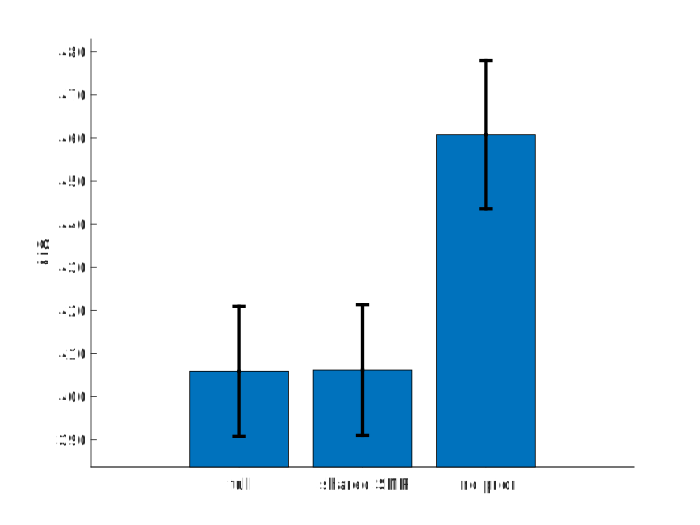

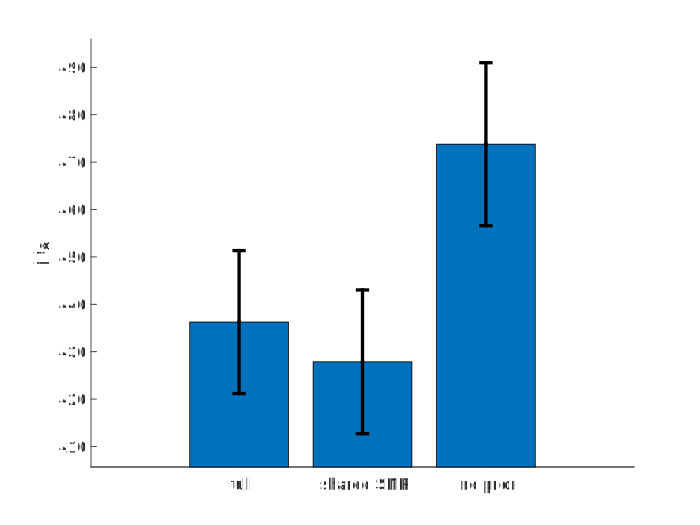

In [7]:
%FINAL

lle_ave = summary_stats(lle,{'LL','aic','bic'},{'model_id','mname','nparam'})

barplot(lle_ave.mean_aic,lle_ave.sem_aic,'xticklabel',{'full','shared SNR','no prior'},'ylabel','AIC');
ylim([min(lle_ave.mean_aic) - max(lle_ave.sem_aic)-5,...
    max(lle_ave.mean_aic) + max(lle_ave.sem_aic)+5])
delta_AIC = diff(lle_ave.mean_aic)
barplot(lle_ave.mean_bic,lle_ave.sem_bic,'xticklabel',{'full','shared SNR','no prior'},'ylabel','bic');
ylim([min(lle_ave.mean_bic) - max(lle_ave.sem_bic)-5,...
    max(lle_ave.mean_bic) + max(lle_ave.sem_bic)+5])
delta_BIC = diff(lle_ave.mean_bic)

In [8]:
%now compute likelihood ratio test (and AIC/BIC diffs) per subject for targeted comparisons
LRT_comps = [
            1 2;
            2 3
            ];

LRT_subj= table();
subj_pc = unique(lle.subject);
for s=1:length(subj_pc)
    this_subj = subj_pc(s);
    this_lle = lle(strcmp(lle.subject,this_subj),:);
    for i=1:size(LRT_comps,1)
        umod = this_lle(this_lle.model_id==LRT_comps(i,1),:); %unrestricted model in matlab lratiotest parlance
        rmod = this_lle(this_lle.model_id==LRT_comps(i,2),:); %restricted model in matlab lratiotest parlance
        this_dof = umod.nparam-rmod.nparam;
        [h,p,stat,cValue] = lratiotest(umod.LL,rmod.LL,this_dof);
        this_lrt = table(h,p,stat,cValue);
        this_lrt.dof = this_dof;
        this_lrt.subject = this_subj;
        this_lrt.comparison = cellstr(sprintf('%d-%d',umod.model_id,rmod.model_id));
        this_lrt.daic = -(umod.aic - rmod.aic); %by convention positive will be evidence for full model (to go along w/ LLR)
        this_lrt.dbic = -(umod.bic - rmod.bic);
        LRT_subj = [LRT_subj;this_lrt];
    end
    clear this_lrt this_lle umod rmod this_subj this_dof
end

LRT_subj.daic01 = double(LRT_subj.daic) > 0;
LRT_subj.dbic01 = double(LRT_subj.dbic) > 0;
LRT_subj.LLR = LRT_subj.stat./2;

In [9]:
LRT_ave = varfun(@mean,LRT_subj,'InputVariables',{'h','LLR','daic','daic01','dbic','dbic01'},...
    'GroupingVariables','comparison')
LRT_ave.model_id = cellfun(@(x) str2double(x{1}),regexp(LRT_ave.comparison,'(\d)-\d','tokens','once'));    
    
fprintf('percent subjects best fit (chi-sq) full vs. shared: %.2f\n',...
    LRT_ave.mean_h(strcmp(LRT_ave.comparison,'1-2')))
fprintf('percent subjects best fit (chi-sq) shared vs. no prior: %.2f\n',...
    LRT_ave.mean_h(strcmp(LRT_ave.comparison,'2-3')))


LRT_ave =

  2x8 table

    comparison    GroupCount    mean_h     mean_LLR    mean_daic    mean_daic01    mean_dbic    mean_dbic01
    __________    __________    _______    ________    _________    ___________    _________    ___________

     {'1-2'}          49         0.2449     2.1474      0.29475       0.40816       -8.3887      0.040816  
     {'2-3'}          49        0.91837     29.302       54.604       0.95918        45.921       0.89796  

percent subjects best fit (chi-sq) full vs. shared: 0.24
percent subjects best fit (chi-sq) shared vs. no prior: 0.92


---
Date: 29-Aug-2022 16:19:33
VB converged in 12 iterations (took ~7 sec).
Dimensions:
     - subjects: n=49
     - models: K=3
Posterior probabilities:
     - RFX: p(H1|y)= 1.000
     - null: p(H0|y)= 0.000

ans =

  3x3 table

            mname               Ef           pep    
    _____________________    _________    __________

    {'priorOnly_full'   }      0.43221       0.17678
    {'priorOnly_noint'  }      0.56098       0.82322
    {'priorOnly_noprior'}    0.0068072    5.3809e-07



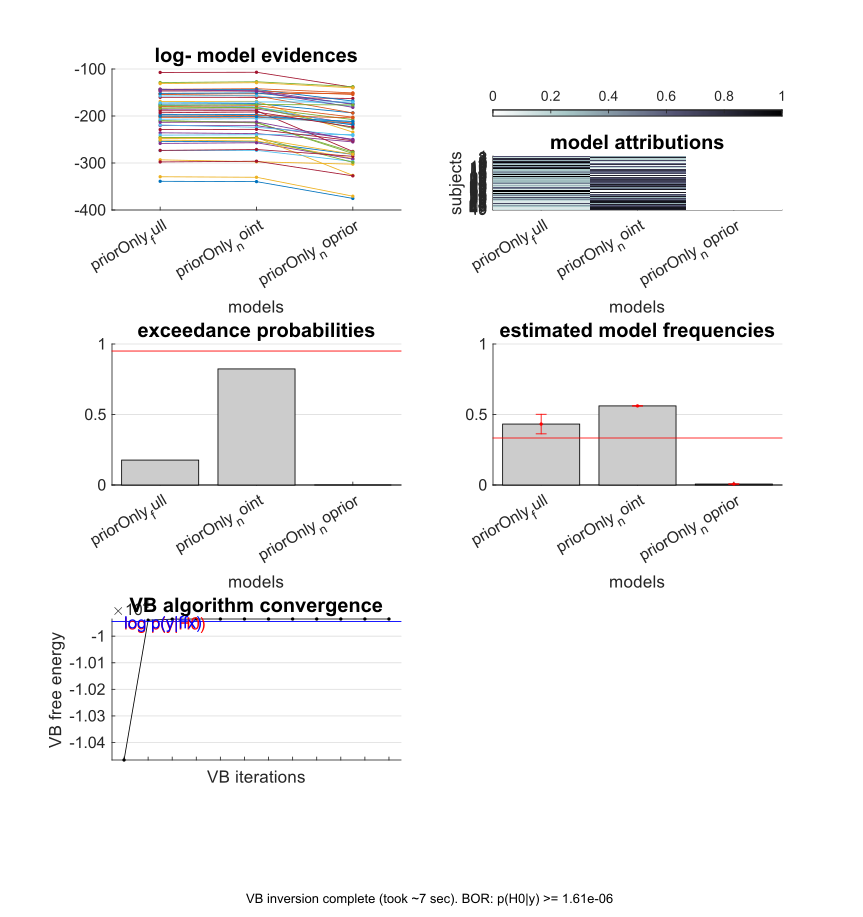

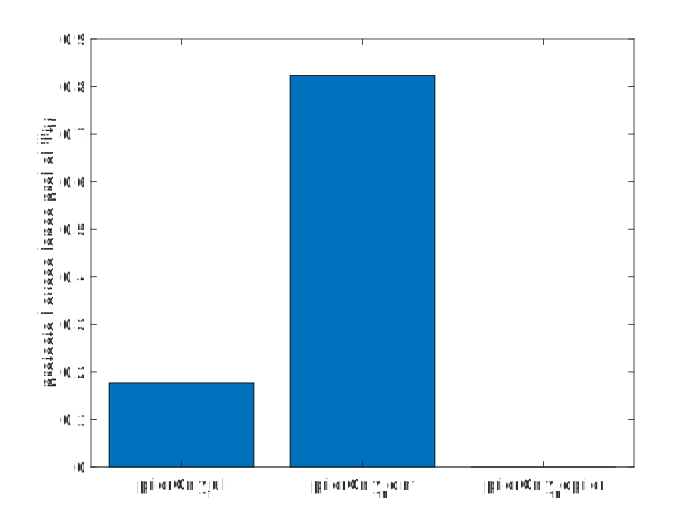

In [10]:
%FINAL

%% now let's look at exceedance probability
lle_VBA = lle(:,{'subject','mname','aic'});
%Stephan et al 2009 AIC is normal AIC/-2 ie log(lle) - k; this is what
%the BMC function expects 
lle_VBA.aic = lle_VBA.aic./-2;
lle_VBA = unstack(lle_VBA,'aic','mname');

opts.MaxIter = 1e4;
opts.modelNames = lle_VBA.Properties.VariableNames(2:end);

[posterior,out] = VBA_groupBMC(lle_VBA{:,2:end}',opts);
%compute protected EP: Rigoux et al., 2014. Code from:
%http://mbb-team.github.io/VBA-toolbox/wiki/BMS-for-group-studies/
out.PEP = (1-out.bor)*out.ep + out.bor/length(out.ep);

out_table = table(out.options.modelNames',out.ep',out.PEP',out.Ef,...
    'VariableNames',{'mname','ep','pep','Ef'});

out_table(:,{'mname','Ef','pep'})

%plot protected exceedance probabilities
figure();bar(categorical(out_table.mname),out_table.pep)
%xticklabels({'full','shared slopes','base','adapt'})
ylabel('protected exceedance probability')

In [11]:
%FINAL (Table 1)

%note, unlike for the DDM fits, the columns past pep relate to how the model on that line fit compared to the model 
%one step below, not all compared to full model

comp_table = lle_ave(:,{'model_id','mname','nparam','mean_aic','mean_bic'});
comp_table = innerjoin(comp_table,out_table,'Keys','mname','RightVariables','pep');
comp_table = outerjoin(comp_table,LRT_ave,'Keys','model_id','RightVariables',...
    {'mean_h','mean_LLR','mean_daic01','mean_dbic01'});
comp_table(:,~ismember(comp_table.Properties.VariableNames,{'model_id'}))


ans =

  3x9 table

            mname            nparam    mean_aic    mean_bic       pep        mean_h     mean_LLR    mean_daic01    mean_dbic01
    _____________________    ______    ________    ________    __________    _______    ________    ___________    ___________

    {'priorOnly_full'   }      7        405.86      436.25        0.17678     0.2449     2.1474       0.40816       0.040816  
    {'priorOnly_noint'  }      5        406.16      427.86        0.82322    0.91837     29.302       0.95918        0.89796  
    {'priorOnly_noprior'}      3        460.76      473.78     5.3809e-07        NaN        NaN           NaN            NaN  



### are "adapt" weights different from 0 in model w/ adaptation-like terms?
NO.

In [12]:
%FINAL
F = load(fullfile(DATA_DIR,fits(4).fitmat));
fits_lapse_adapt = F.fits_lapse;clear F

prior_suffix = {'low','no','high'};

%are adapt weights different from 0?
for p=1:length(prior_suffix)
    [pval,h,stats] = signtest(fits_lapse_adapt.(['aSNR_' prior_suffix{p}]))
end


pval =

    0.5682


h =

  logical

   0


stats = 

  struct with fields:

    zval: NaN
    sign: 27


pval =

    0.3916


h =

  logical

   0


stats = 

  struct with fields:

    zval: NaN
    sign: 28


pval =

    1.0000


h =

  logical

   0


stats = 

  struct with fields:

    zval: NaN
    sign: 25

